# Programming Exercise 7: K-means Clustering and Principal Component Analysis

# 1 K-means Clustering

# 1.1 Implementing K-means

In [187]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

mat = loadmat('data/ex7data2.mat')
X = mat['X']
X.shape

(300, 2)

# 1.2 K-means on example dataset
# 1.3 Random initialization


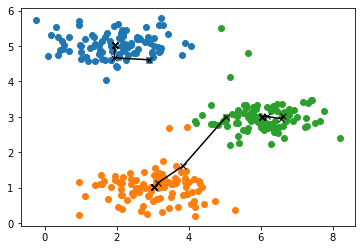

In [188]:
from matplotlib import rcParams

def kmeans_init_centroids(X, K):
    X_shuffle = X.copy()
    np.random.shuffle(X_shuffle) # shuffling is to avoid repeat selection
    return X_shuffle[:K]

def find_closest_centroids(X, centroids):
    return np.array([np.argmin([np.linalg.norm(x - centroid, ord=2) ** 2 for centroid in centroids]) for x in X])

def compute_centroids(X, idx, K):
    return np.array([X[idx == k].mean(axis=0) for k in range(K)])

def compute_distance(X, centroids):
    return sum(sum(np.linalg.norm(x - centroid, ord=2) ** 2 for centroid in centroids) for x in X)

def get_centroids_arr(X, K, iter_num):
    centroids_arr = [kmeans_init_centroids(X, K)]
    for _ in range(iter_num):
        centroids_arr.append(compute_centroids(X, find_closest_centroids(X, centroids_arr[-1]), K))
    return np.array(centroids_arr)

def plot_centroids(X, K, centroids_arr):
    colors = list(map(lambda dct: dct['color'], list(rcParams['axes.prop_cycle'])[:K]))
    idx = find_closest_centroids(X, centroids_arr[-1])
    for k in range(K):
        plt.scatter(*zip(*X[idx == k]), color=colors[k])
        plt.plot(*zip(*centroids_arr[:, k, :]), marker='x', color='black')

K = 3
centroids_arr_lst = [get_centroids_arr(X, K, 20) for _ in range(20)]
distance_lst = [compute_distance(X, centroids_arr[-1]) for centroids_arr in centroids_arr_lst]
centroids_arr = centroids_arr_lst[np.argmin(distance_lst)]
plot_centroids(X, K, centroids_arr)

多次测试，感觉还是有很多时候分类不够好，可能是 compute_distance 这个函数本身就不合适？distance 平方和最小真的就是全局最优吗，感觉还是经常得到局部最优。

# 1.4 Image compression with K-means

In [222]:
img = plt.imread('data/bird_small.png')
img_shape = img.shape
img = img.reshape((img.shape[0] * img.shape[1], img.shape[2]))
img.shape

(16384, 3)

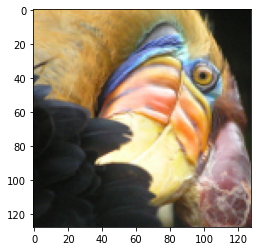

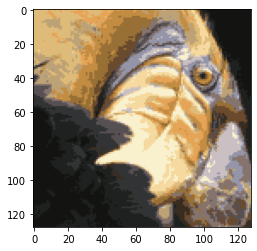

In [190]:
K = 16
X = img

centroids_arr_lst = [get_centroids_arr(X, K, 5) for _ in range(5)]
distance_lst = [compute_distance(X, centroids_arr[-1]) for centroids_arr in centroids_arr_lst]
centroids_arr = centroids_arr_lst[np.argmin(distance_lst)]
idx = find_closest_centroids(X, centroids_arr[-1])

plt.imshow(img.reshape(img_shape))
plt.show()

img_kmeans = np.array([centroids_arr[-1, i] for i in idx]).reshape(img_shape)
plt.imshow(img_kmeans)
plt.show()

压缩节约空间计算（这里是假设 RGB 通道取值都是 0 - 255，但其实其取值是 0 - 1 浮点数）：
- 原始 bit 数：128 * 128 * 3 * 8 = 393216
- 压缩 bit 数：128 * 128 * 4 + 16 * 3 * 8 = 65920
- 压缩比：5.96504854

# 2 Principal Component Analysis

# 2.1 Example Dataset

In [191]:
X = loadmat('data/ex7data1.mat')['X']
X.shape

(50, 2)

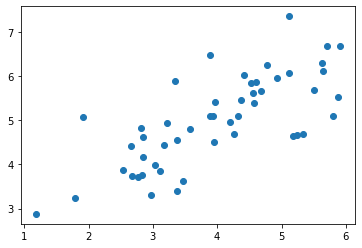

In [192]:
plt.scatter(*zip(*X))
plt.show()

# 2.2 Implementing PCA

In [193]:
def feature_normalize(X):
    return (X - X.mean(axis=0)) / X.std(axis=0)

X = feature_normalize(X)

In [194]:
m = len(X)
Sigma = 1 / m * X.T @ X
U, S, V = np.linalg.svd(Sigma)

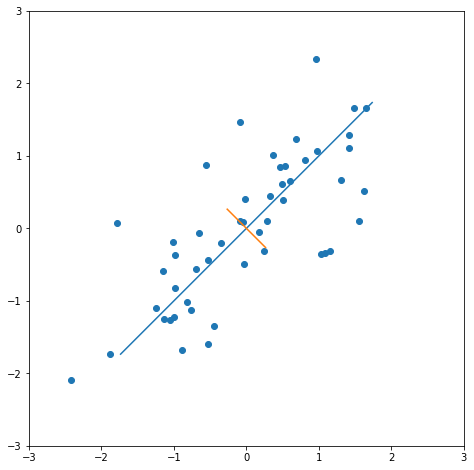

In [195]:
plt.figure(figsize=(8, 8))
plt.gca().set_aspect(1)
plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.scatter(*zip(*X))

Xplot = np.concatenate([np.linspace(-S[0], S[0])[:, None], np.linspace(-S[1], S[1])[:, None]], axis=1)
Yplot = Xplot * U[1, :] / U[0, :] # y = x / u1 * u2，u 是向量两轴的投影
plt.plot(Xplot[:, 0], Yplot[:, 0])
plt.plot(Xplot[:, 1], Yplot[:, 1])
plt.show()

X 已经规范化了，所以从原点开始画向量（U）就可以。另外向量的长度可以用方差（S）代表，表示在这个维度上体现了多大的的方差。

# 2.3 Dimensionality Reduction with PCA

In [196]:
K = 1
Ureduce = U[:, 0:K]
Z = X @ Ureduce
Z.shape, Z[0]

((50, 1), array([1.49631261]))

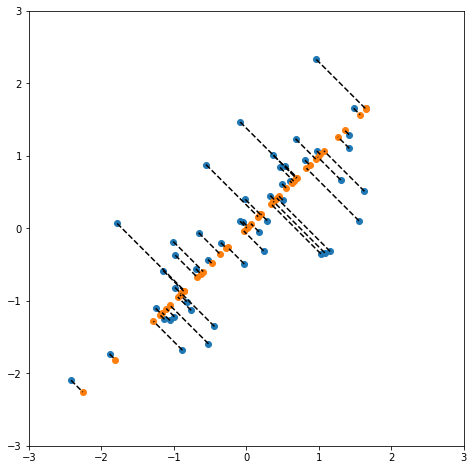

In [197]:
plt.figure(figsize=(8, 8))
plt.gca().set_aspect(1)
plt.xlim(-3, 3)
plt.ylim(-3, 3)

X_rec = Z @ Ureduce.T
plt.scatter(*zip(*X))
plt.scatter(*zip(*X_rec))

for p1, p2 in zip(X, X_rec):
    plt.plot(*zip(p1, p2), ls='--', c='k')

plt.show()

思考：U 到底是什么？U 是单位向量，每一列都是 PCA 组成的单位向量（按照 S 大小从最大开始排序）。

# 2.4 Face Image Dataset

In [198]:
X = loadmat('data/ex7faces.mat')['X']
X.shape

(5000, 1024)

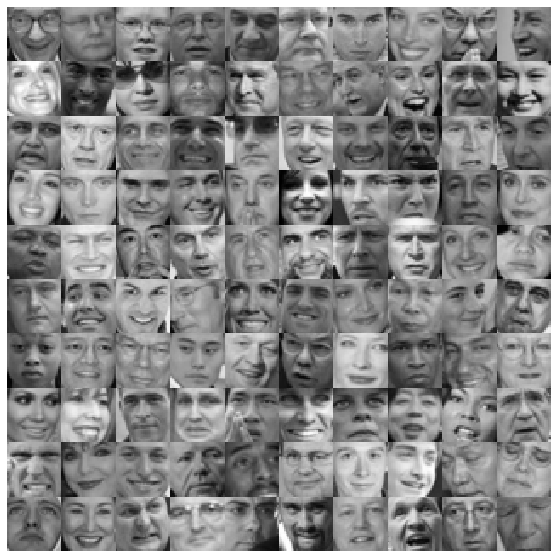

In [199]:
def plot_faces(src):
    """输入的 src 的 shape[0] 必须是平方数"""
    size = round(src.shape[0] ** 0.5)
    data = np.zeros((32 * size, 32 * size))
    def modify(i, j):
        data[32 * i: 32 * (i + 1), 32 * j: 32 * (j + 1)] = src[i * size + j, :].reshape((32, 32)).T
    [modify(i, j) for i in range(size) for j in range(size)]

    fig = plt.figure(figsize=(size, size))
    ax = fig.gca()
    ax.matshow(data, cmap='gray')

    plt.axis('off')
    plt.show()

plot_faces(X[:100])

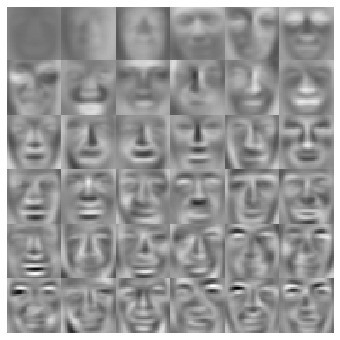

In [200]:
X_norm = feature_normalize(X)
m = len(X_norm)
Sigma = 1 / m * X_norm.T @ X_norm
U, S, V = np.linalg.svd(Sigma)
plot_faces(U.T[:36]) # 差点忘了，取转置，搞了半天出不来

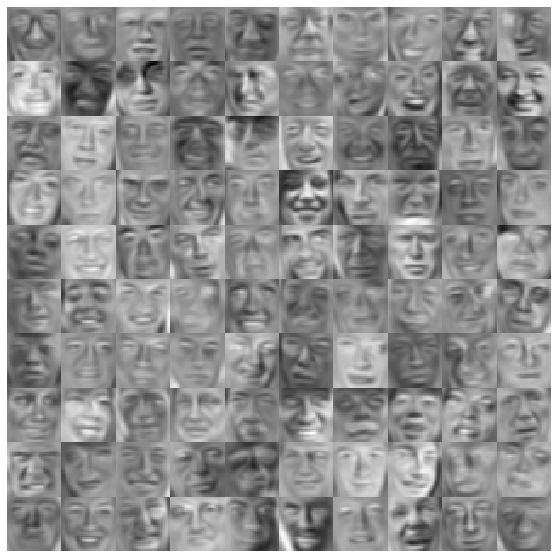

In [201]:
K = 100
Ureduce = U[:, 0:K]
Z = X_norm @ Ureduce
X_rec = Z @ Ureduce.T

plot_faces(X_rec[:100])

# 2.5 Optional (ungraded) exercise: PCA for visualization

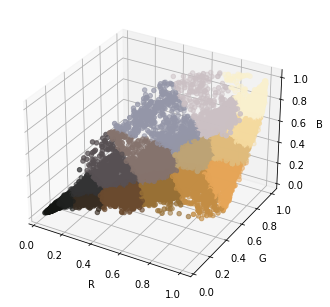

In [219]:
from mpl_toolkits.mplot3d import Axes3D

X = img
ax = Axes3D(plt.figure())
ax.scatter(*zip(*X), c=np.array([centroids_arr[-1][i] for i in idx]))
ax.set_xlabel(r'R')
ax.set_ylabel(r'G')
ax.set_zlabel(r'B')

plt.show()

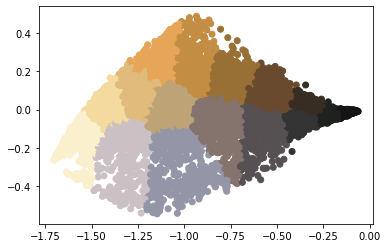

In [229]:
K = 2

m = len(X)
Sigma = 1 / m * X.T @ X
U, S, V = np.linalg.svd(Sigma)

Ureduce = U[:, 0:K]
Z = X @ Ureduce

plt.scatter(*zip(*Z), c=np.array([centroids_arr[-1][i] for i in idx]))
plt.show()